In [1]:
from opendrift.readers import reader_netCDF_CF_generic
from opendrift.models.openberg import OpenBerg
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt

import sys, os

In [2]:
source_url = "https://thredds.met.no/thredds/dodsC/fou-hi/barents_eps_zdepth/barents_zdepth_20230319T00Zm00_AN.nc"
source_url = "netcdf_cache/barents_zdepth_20230319T00Zm00_AN.nc"
#wind_url = "https://thredds.met.no/thredds/dodsC/aromearcticarchive/2023/03/19/arome_arctic_det_2_5km_20230319T00Z.nc"
os.path.isfile(source_url)

True

In [3]:
reader_barents = reader_netCDF_CF_generic.Reader(source_url)
reader_barents.start_time
#reader_wind = reader_netCDF_CF_generic.Reader(wind_url)

datetime.datetime(2023, 3, 19, 0, 0)

In [4]:
#reader_barents.Dataset

In [5]:
models = [None]*300
kd = np.random.uniform(20, 200, len(models))
wl = np.random.uniform(70, 500, len(models))
wind = np.random.uniform(0, 0.04, len(models))
print(kd)
print(wl)
for i in range(len(models)):
    models[i] = OpenBerg(loglevel=50)

    #o.add_reader([reader_barents, reader_wind])
    models[i].add_reader(reader_barents)

    models[i].seed_elements(lat=78.06050109863281, lon=11.486795425415039, time=reader_barents.start_time, number=1, keel_depth=kd[i], water_line_length=wl[i], wind_drift_factor=wind[i])
    
    models[i].run(duration = timedelta(hours=12), time_step = 3600, time_step_output = 3600)


[117.90633398  62.01858016 160.81380816  73.61646431 179.44035754
 156.25876117  36.91003393  40.13580233 148.17725108 168.69265236
 196.02765982  24.24217951  67.84888766 163.35910279 146.63357998
  70.00664903  34.58518609 172.09736336  93.58418722  45.15737678
 137.43556461 170.6273005   49.76125211 158.50759023  23.23254042
 108.11580486 192.57766442 101.41395369 143.01132713 182.43322953
  90.11775705  97.43323431 165.40230143  32.70201066 175.19845623
  94.00483113 153.20275334 119.06524608  24.89266624 182.3226215
 146.40388401 162.18772123 185.53324071  42.78081292 183.14162593
 147.81634942  48.31894776 190.68452041 159.50509568 140.74285108
 127.23374241  77.15571731 144.19281326 188.76637854  31.16254176
  38.1051271  160.01014843  27.67296387  95.6997959  112.65601687
 104.67447946  96.47735951 110.5005011   76.54753128 177.28454318
 137.79537505 126.75204517  59.15426081  28.02598276  48.05937104
 125.58786659  66.88648736 116.00131948  79.35037278  90.95668283
 145.373290

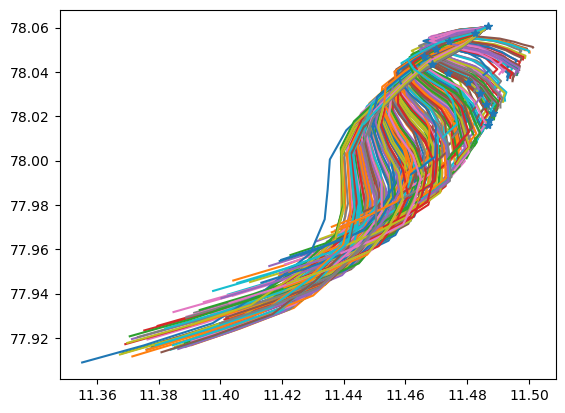

In [17]:
for i in range(len(models)):
    plt.plot([m[5] for m in models[i].history[0]], [m[6] for m in models[i].history[0]], label=str(i))
    #plt.legend()
    #print(models[i].history)

plt.plot([m[5] for m in models[0].history[0]], [m[6] for m in models[0].history[0]], '*')


In [7]:
prior_kd   = [m.history[0][0][10] for m in models]
priod_wl   = [m.history[0][0][ 9] for m in models]
priod_wind = [m.history[0][0][ 8] for m in models]

In [8]:
end_lon = [m.history[0][-1][5] for m in models]
end_lat = [m.history[0][-1][6] for m in models]

In [9]:
obs_lon = end_lon[0]
obs_lat = end_lat[0]

offset_d = np.sqrt((end_lon[1:] - obs_lon)**2 + (end_lat[1:] - obs_lat)**2)
#print(offset_d)



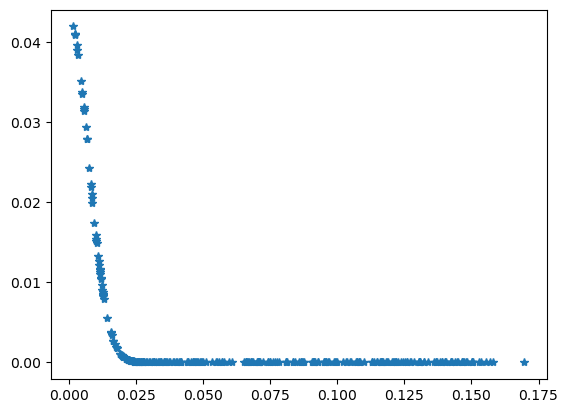

In [21]:
R = 0.0001
weight = np.exp(-offset_d**2/R)
weight /= np.sum(weight)

#print(weight)

plt.plot(offset_d, weight, '*')

(array([  8.73897752,  17.47795504,   0.        ,   0.        ,
          0.        ,   8.73897752,  52.43386511,  43.69488759,
         43.69488759,  34.95591007,  34.95591007, 297.12523561,
        209.73546043, 166.04057284, 279.64728058, 384.51501079,
         87.38977518,  96.1287527 , 166.04057284,  96.1287527 ,
        104.86773022, 166.04057284,  43.69488759,  43.69488759,
        157.30159532,   0.        ,   8.73897752,  26.21693255,
         26.21693255,   8.73897752]),
 array([0.00316852, 0.00355123, 0.00393394, 0.00431665, 0.00469936,
        0.00508207, 0.00546477, 0.00584748, 0.00623019, 0.0066129 ,
        0.00699561, 0.00737832, 0.00776103, 0.00814373, 0.00852644,
        0.00890915, 0.00929186, 0.00967457, 0.01005728, 0.01043999,
        0.01082269, 0.0112054 , 0.01158811, 0.01197082, 0.01235353,
        0.01273624, 0.01311895, 0.01350165, 0.01388436, 0.01426707,
        0.01464978]),
 <BarContainer object of 30 artists>)

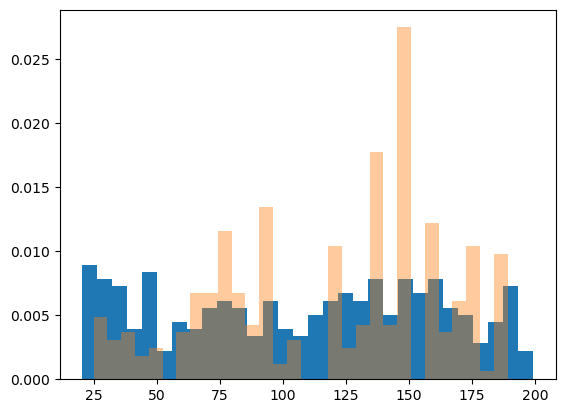

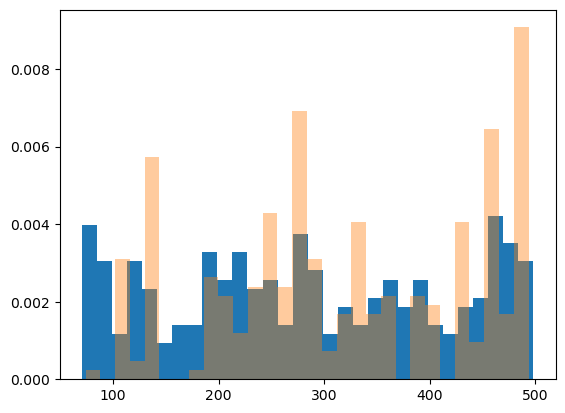

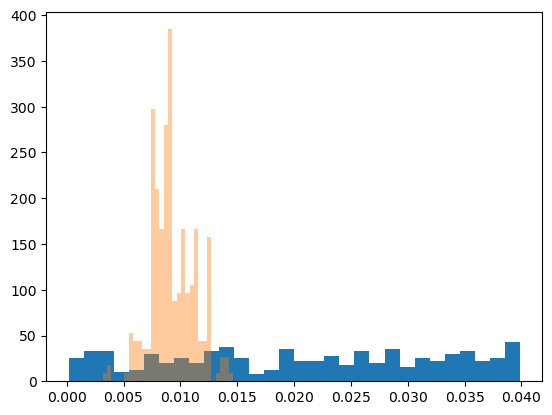

In [25]:
ids_to_resample = np.random.choice(np.arange(1,len(prior_kd)), len(prior_kd) - 1, p=weight)

posterior_kd   = np.zeros_like(ids_to_resample, dtype=float)
posterior_wl   = np.zeros_like(ids_to_resample, dtype=float)
posterior_wind = np.zeros_like(ids_to_resample, dtype=float)
for i in range(len(ids_to_resample)):
    posterior_kd[i]   = prior_kd[ids_to_resample[i]]
    posterior_wl[i]   = priod_wl[ids_to_resample[i]]
    posterior_wind[i] = priod_wind[ids_to_resample[i]]

fig = plt.figure()
plt.hist(prior_kd, bins=30, density=True)
plt.hist(posterior_kd, bins=30, density=True, alpha=0.4)
fig = plt.figure()
plt.hist(priod_wl, bins=30, density=True)
plt.hist(posterior_wl, bins=30, density=True, alpha=0.4)
fig = plt.figure()
plt.hist(priod_wind, bins=30, density=True)
plt.hist(posterior_wind, bins=30, density=True, alpha=0.4)

#plt.plot(weight)
#fig = plt.figure()
#plt.hist(weight[ids_to_resample], bins=20)

(array([1.21500242e-06, 2.43000484e-06, 1.09350218e-05, 2.30850460e-05,
        2.91600581e-05, 2.43000484e-05, 3.15900629e-05, 4.86000968e-06,
        3.64500726e-06, 2.06550411e-05, 1.57950314e-05, 2.43000484e-05,
        4.25250847e-05, 0.00000000e+00, 1.33650266e-05, 9.72001935e-06,
        1.21500242e-05, 0.00000000e+00, 0.00000000e+00, 2.67300532e-05,
        0.00000000e+00, 0.00000000e+00, 2.55150508e-05, 0.00000000e+00,
        1.94400387e-05, 0.00000000e+00, 3.64500726e-06, 2.43000484e-06,
        0.00000000e+00, 1.57950314e-05]),
 array([ 3538.10092274,  6290.75519964,  9043.40947654, 11796.06375344,
        14548.71803034, 17301.37230724, 20054.02658414, 22806.68086104,
        25559.33513794, 28311.98941484, 31064.64369174, 33817.29796864,
        36569.95224554, 39322.60652244, 42075.26079933, 44827.91507623,
        47580.56935313, 50333.22363003, 53085.87790693, 55838.53218383,
        58591.18646073, 61343.84073763, 64096.49501453, 66849.14929143,
        69601.80356833

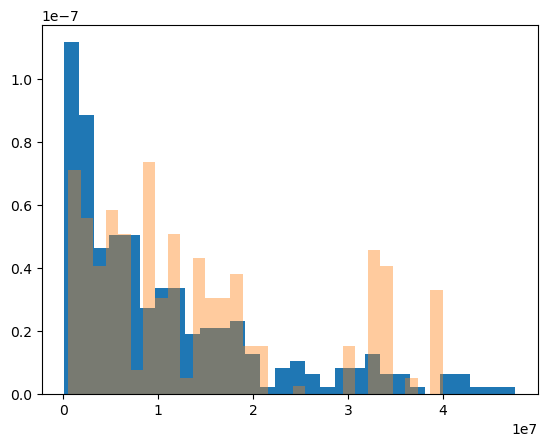

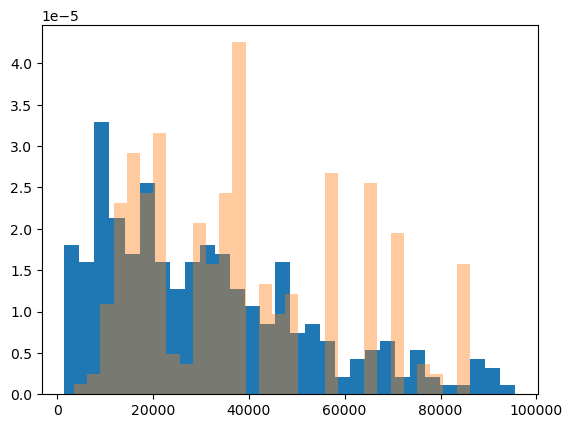

In [28]:
fig = plt.figure()
plt.hist(np.array(prior_kd)*np.array(priod_wl)*np.array(priod_wl), bins=30, density=True)
plt.hist(np.array(posterior_kd)*np.array(posterior_wl)*np.array(posterior_wl), bins=30, density=True, alpha=0.4)

fig = plt.figure()
plt.hist(np.array(prior_kd)*np.array(priod_wl), bins=30, density=True)
plt.hist(np.array(posterior_kd)*np.array(posterior_wl), bins=30, density=True, alpha=0.4)


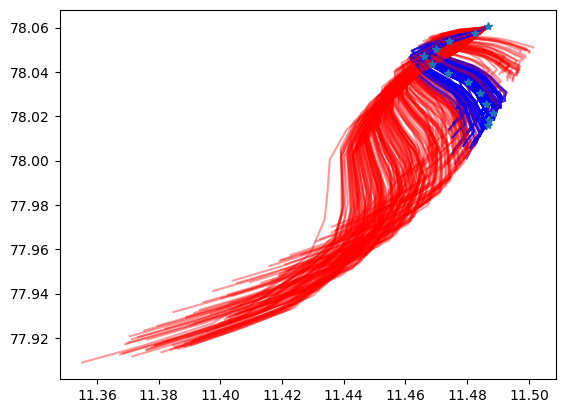

In [23]:
for i in range(len(ids_to_resample)):
    plt.plot([m[5] for m in models[ids_to_resample[i]].history[0]], [m[6] for m in models[ids_to_resample[i]].history[0]], 'b', alpha=0.4)
    plt.plot([m[5] for m in models[i+1].history[0]], [m[6] for m in models[i+1].history[0]], 'r', alpha=0.4)
plt.plot([m[5] for m in models[0].history[0]], [m[6] for m in models[0].history[0]], '*')


In [14]:
for i in range(3):
    print(models[i].history)

[[(1, 0, 1, 3600.0, 0, 11.486795425415039, 78.06050109863281, 0.0, 0.009752714075148106, 390.83453369140625, 117.90633392333984, -1.1450854539871216, -8.151657104492188, 0.2283029556274414, 0.014253014698624611, 0.0)
  (1, 0, 1, 7200.0, 0, 11.482539176940918, 78.05738830566406, 0.0, 0.009752714075148106, 390.83453369140625, 117.90633392333984, -1.6145672798156738, -8.30189323425293, 0.22320222854614258, -0.20129406452178955, 0.0)
  (1, 0, 1, 10800.0, 0, 11.474235534667969, 78.05403900146484, 0.0, 0.009752714075148106, 390.83453369140625, 117.90633392333984, -1.637549638748169, -7.2794599533081055, -0.044302817434072495, -0.007067839149385691, 0.0)
  (1, 0, 1, 14400.0, 0, 11.469862937927246, 78.05047607421875, 0.0, 0.009752714075148106, 390.83453369140625, 117.90633392333984, -1.9884933233261108, -8.212607383728027, 0.09374143183231354, -0.035509586334228516, 0.0)
  (1, 0, 1, 18000.0, 0, 11.466058731079102, 78.04713439941406, 0.0, 0.009752714075148106, 390.83453369140625, 117.9063339233

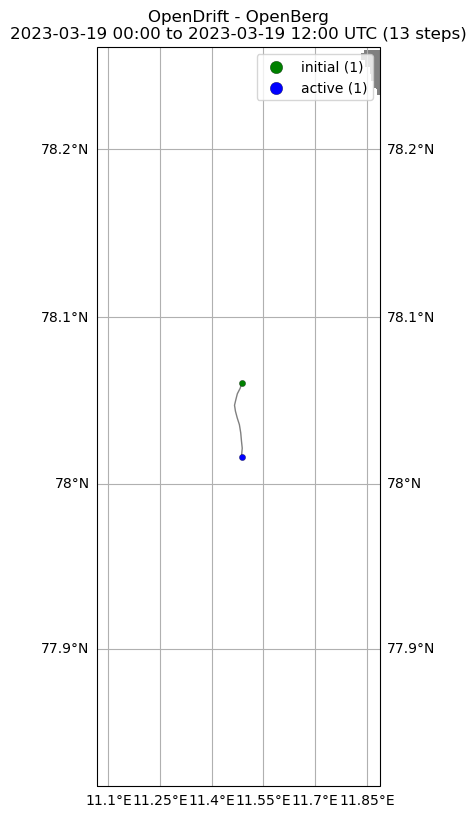

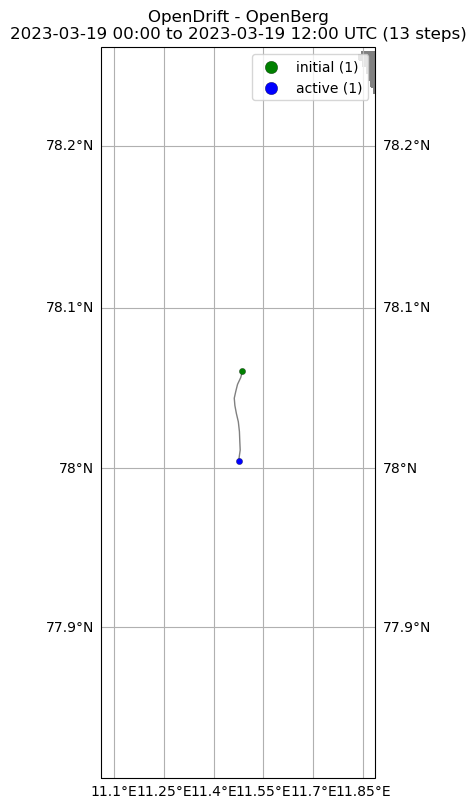

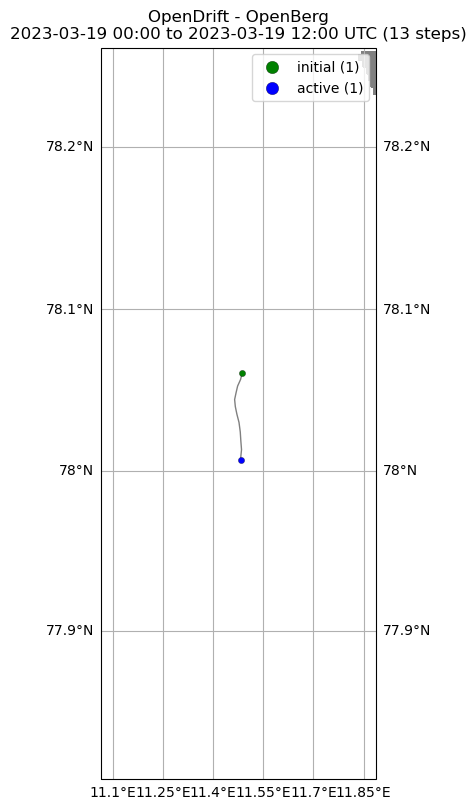

In [24]:
for i in range(3):
    models[i].plot(fast=True)

In [16]:
print(o.list_configspec())

NameError: name 'o' is not defined

In [ ]:
o.history_metadata

OrderedDict([('ID', {'dtype': numpy.int32, 'seed': False, 'default': -1}),
             ('status', {'dtype': numpy.int32, 'seed': False, 'default': 0}),
             ('moving', {'dtype': numpy.int32, 'seed': False, 'default': 1}),
             ('age_seconds',
              {'dtype': numpy.float32,
               'units': 's',
               'seed': False,
               'default': 0}),
             ('origin_marker',
              {'dtype': numpy.int32,
               'unit': '',
               'description': 'An integer kept constant during the simulation. Different values may be used for different seedings, to separate elements during analysis. With GUI, only a single seeding is possible.',
               'default': 0}),
             ('lon',
              {'dtype': numpy.float32,
               'units': 'degrees_east',
               'standard_name': 'longitude',
               'long_name': 'longitude',
               'seed': False,
               'axis': 'X'}),
             ('lat',
 

In [ ]:
o.history

masked_array(
  data=[[(1, 0, 1, 3600.0, 0, 11.486795425415039, 77.06050109863281, 0.0, 0.017999999225139618, 50.0, 60.0, -3.035505533218384, -4.877555847167969, 0.0314035639166832, -0.00857530441135168, 0.0),
         (1, 0, 1, 46800.0, 0, 11.518120765686035, 76.95036315917969, 0.0, 0.017999999225139618, 50.0, 60.0, -2.6097865104675293, -9.776449203491211, -0.05230240896344185, 0.18222758173942566, 0.0),
         (1, 0, 1, 86400.0, 0, 11.613330841064453, 76.85945129394531, 0.0, 0.017999999225139618, 50.0, 60.0, 6.4813432693481445, -9.61042594909668, 0.106267049908638, -0.002038596896454692, 0.0)],
        [(2, 0, 1, 3600.0, 1, 11.486795425415039, 77.06050109863281, 0.0, 0.017999999225139618, 50.0, 60.0, -3.09060001373291, -5.727174282073975, 0.22793805599212646, -0.10447970777750015, 0.0),
         (2, 0, 1, 46800.0, 1, 11.51864242553711, 76.95088958740234, 0.0, 0.017999999225139618, 50.0, 60.0, -3.0913403034210205, -8.391378402709961, -0.10204647481441498, 0.11555574834346771, 0.0),
